In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
import pandas_datareader.data as web
from sklearn.preprocessing import StandardScaler
import math
from sklearn.metrics import mean_squared_error

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


### US sector ETFs:
    Financial Services: XLF
    Energy: XLE
    Utilities: XLU
    Healthcare: XLV
    Industrials: XLI
    Technology: XLK
    Consumer Cyclical: XLY
    Consumer Defensive: XLP
    Basic Materials: XLB
    Communication Services: XLC
    Real Estate: XLRE
### macro factors:
    USD/JPY
    WTI Futures
    Gold Futures
    10-year Bond
    VIX
    S&P500

## Data Collection and Cleaning

In [4]:
start_date = '2010-01-01'
end_date = '2021-09-15'

In [2]:
oil = web.DataReader(name = 'CL=F',data_source = 'yahoo', start = start_date, end = end_date)['Adj Close']
gold = web.DataReader(name = 'GC=F',data_source = 'yahoo', start = start_date, end = end_date)['Adj Close']
bond = web.DataReader(name = '^TNX',data_source = 'yahoo', start = start_date, end = end_date)['Adj Close']
vix = web.DataReader(name = '^VIX',data_source = 'yahoo', start = start_date, end = end_date)['Adj Close']
USD_JPY = web.DataReader(name = 'JPY=X',data_source = 'yahoo', start = start_date, end = end_date)['Adj Close']
SPX = web.DataReader(name = '^GSPC',data_source = 'yahoo', start = start_date, end = end_date)['Adj Close']


In [3]:
macro_data = pd.DataFrame([oil,gold,bond,vix,USD_JPY,SPX]).T
macro_data.columns= ['oil','gold','bond','vix','USD_JPY','SPX']
macro_data = macro_data.dropna()
macro_data


,oil,gold,bond,vix,USD_JPY,SPX
Date,,,,,,
2010-01-04,81.510002,1117.699951,3.841,20.040001,92.495003,1132.989990
2010-01-05,81.769997,1118.099976,3.755,19.350000,91.584999,1136.520020
2010-01-06,83.180000,1135.900024,3.808,19.160000,92.356003,1137.140015
2010-01-07,82.660004,1133.099976,3.822,19.059999,93.389999,1141.689941
2010-01-08,82.750000,1138.199951,3.808,18.129999,92.660004,1144.979980
...,...,...,...,...,...,...
2021-09-08,69.300003,1790.699951,1.334,17.959999,110.218002,4514.069824
2021-09-09,68.139999,1797.400024,1.299,18.799999,109.780998,4493.279785
2021-09-13,70.449997,1792.000000,1.324,19.370001,109.994003,4468.729980


In [12]:
def getSectorData(ticker, start_date, end_date):
    df = web.DataReader(name = ticker,data_source = 'yahoo', start = start_date, end = end_date)
    #df = pd.merge(df,macro_data,left_index=True, right_index=True)
    df= df.dropna()
    df= df.drop(['Close'], axis = 1 )
    df["Return of the Day"] = df['Adj Close'].pct_change()
    df["Next Day Return"] = df['Adj Close'].pct_change().shift(-1)
    df = df[1:-1]
    return df

In [13]:
XLF = getSectorData('XLF', start_date, end_date)
XLE = getSectorData('XLE', start_date, end_date)
XLU = getSectorData('XLU', start_date, end_date)
XLV = getSectorData('XLV', start_date, end_date)
XLI = getSectorData('XLI', start_date, end_date)
XLK = getSectorData('XLK', start_date, end_date)
XLY = getSectorData('XLY', start_date, end_date)
XLP = getSectorData('XLP', start_date, end_date)
XLB = getSectorData('XLB', start_date, end_date)
XLC = getSectorData('XLC', start_date, end_date)
XLRE = getSectorData('XLRE', start_date, end_date)


In [14]:
def getTrainTestData(df,datetime):
    df_train = df[df.index<=datetime]
    df_test = df[df.index>datetime]
    return df_train, df_test
    

In [15]:
date = dt.datetime(2018,12,31)
XLF_train, XLF_test = getTrainTestData(XLF,date)
XLE_train, XLE_test = getTrainTestData(XLE,date)
XLU_train, XLU_test = getTrainTestData(XLU,date)
XLV_train, XLV_test = getTrainTestData(XLV,date)
XLI_train, XLI_test = getTrainTestData(XLI,date)
XLK_train, XLK_test = getTrainTestData(XLK,date)
XLY_train, XLY_test = getTrainTestData(XLY,date)
XLP_train, XLP_test = getTrainTestData(XLP,date)
XLB_train, XLB_test = getTrainTestData(XLB,date)
XLC_train, XLC_test = getTrainTestData(XLC,date)
XLRE_train, XLRE_test = getTrainTestData(XLRE,date)

In [16]:
XLF_test

,High,Low,Open,Volume,Adj Close,Return of the Day,Next Day Return
Date,,,,,,,
2019-01-02,24.070000,23.400000,23.469999,62945000.0,22.455425,0.008396,-0.022481
2019-01-03,23.900000,23.420000,23.840000,65729700.0,21.950600,-0.022481,0.033220
2019-01-04,24.309999,23.820000,23.879999,64638400.0,22.679792,0.033220,0.001237
2019-01-07,24.510000,24.059999,24.209999,48167000.0,22.707838,0.001237,0.000823
2019-01-08,24.549999,24.030001,24.510000,90114700.0,22.726532,0.000823,0.004936
...,...,...,...,...,...,...,...
2021-09-08,37.930000,37.549999,37.750000,32523900.0,37.262253,-0.002379,0.002914
2021-09-09,38.220001,37.669998,37.700001,33421000.0,37.370831,0.002914,-0.007396
2021-09-10,38.110001,37.570000,38.070000,39350500.0,37.094452,-0.007396,0.011442


### Feature engineering (Standardization)

In [17]:
def scaleData(train, test):
    scaler = StandardScaler()
    temp = scaler.fit_transform(train)
    
    #col_mean = scaler.mean_[-1]
    #col_std = np.sqrt(scaler.var_)[-1]
    
    dctMean = {}
    dctStd = {}
    for col in train.columns:
        dctMean[col] =train[col].mean()
        dctStd[col] = train[col].std()    
    
    # Convert the numpy array back into pandas dataframe
    train_scaled = pd.DataFrame(temp, columns=train.columns, index = train.index)
    temp_test = scaler.transform(test)
    test_scaled = pd.DataFrame(temp_test, columns = train.columns, index = test.index)
    return train_scaled, test_scaled, dctMean, dctStd

In [18]:
XLF_train_scaled, XLF_test_scaled, XLF_mean, XLF_std = scaleData(XLF_train, XLF_test)

## XG Boost

In [19]:
def get_mape(y_true, y_pred): 
    """
    Compute mean absolute percentage error (MAPE)
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def train_pred_eval_model(X_train_scaled, y_train_scaled, X_test_scaled, y_test_scaled, y_mean, y_std, seed = 42, \
                          n_estimators = 30, max_depth = 7, learning_rate=0.1, min_child_weight=1, subsample=1, \
                          colsample_bytree=1, colsample_bylevel=1, gamma=0):

    model = xgb.XGBRegressor(seed = random_seed,
                             n_estimators = n_estimators,
                             max_depth = max_depth,
                             learning_rate = learning_rate,
                             min_child_weight = min_child_weight,
                             subsample = subsample,
                             colsample_bytree = colsample_bytree,
                             colsample_bylevel = colsample_bylevel,
                             gamma=gamma)
   
    # Train the model
    model.fit(X_train_scaled, y_train_scaled)
   
    # Get predicted labels and scale back to original range
    y_pred_scaled = model.predict(X_test_scaled)
    y_pred = y_pred_scaled * y_std + y_mean
    y_test = y_test_scaled * y_std + y_mean
    # Calculate RMSE
    rmse = math.sqrt(mean_squared_error(y_test, y_pred))
#   mape = get_mape(y_test, est)
    return rmse, y_pred

In [21]:
#XLF
XLF_train_scaled, XLF_test_scaled, XLF_mean, XLF_std = scaleData(XLF_train, XLF_test)
features = ['High','Low','Open','Volume','Adj Close','Return of the Day']
#features = ['High','Low','Open','Volume','Adj Close','oil','gold','bond','vix','USD_JPY','SPX','Return of the Day']

random_seed = 0
XLF_test_n = XLF_test.copy()
XLF_rmse, XLF_test_n['Next Day Return Pred'] = train_pred_eval_model(XLF_train_scaled[features], \
                                                      XLF_train_scaled['Next Day Return'], \
                                                      XLF_test_scaled[features], \
                                                      XLF_test_scaled['Next Day Return'], \
                                                      XLF_mean['Next Day Return'], XLF_std['Next Day Return'])
print("RMSE on test set = %0.3f" % XLF_rmse)

RMSE on test set = 0.019


In [22]:
#XLE
XLE_train_scaled, XLE_test_scaled, XLE_mean, XLE_std = scaleData(XLE_train, XLE_test)
XLE_test_n = XLE_test.copy()
XLE_rmse, XLE_test_n['Next Day Return Pred'] = train_pred_eval_model(XLE_train_scaled[features], \
                                                      XLE_train_scaled['Next Day Return'], \
                                                      XLE_test_scaled[features], \
                                                      XLE_test_scaled['Next Day Return'], \
                                                      XLE_mean['Next Day Return'], XLE_std['Next Day Return'])
print("RMSE on test set = %0.3f" % XLE_rmse)

RMSE on test set = 0.027


In [23]:
#XLU
XLU_train_scaled, XLU_test_scaled, XLU_mean, XLU_std = scaleData(XLU_train, XLU_test)
XLU_test_n = XLU_test.copy()
XLU_rmse, XLU_test_n['Next Day Return Pred'] = train_pred_eval_model(XLU_train_scaled[features], \
                                                      XLU_train_scaled['Next Day Return'], \
                                                      XLU_test_scaled[features], \
                                                      XLU_test_scaled['Next Day Return'], \
                                                      XLU_mean['Next Day Return'], XLU_std['Next Day Return'])
print("RMSE on test set = %0.3f" % XLU_rmse)

RMSE on test set = 0.016


In [24]:
#XLV
XLV_train_scaled, XLV_test_scaled, XLV_mean, XLV_std = scaleData(XLV_train, XLV_test)
XLV_test_n = XLV_test.copy()
XLV_rmse, XLV_test_n['Next Day Return Pred'] = train_pred_eval_model(XLV_train_scaled[features], \
                                                      XLV_train_scaled['Next Day Return'], \
                                                      XLV_test_scaled[features], \
                                                      XLV_test_scaled['Next Day Return'], \
                                                      XLV_mean['Next Day Return'], XLV_std['Next Day Return'])
print("RMSE on test set = %0.3f" % XLV_rmse)

RMSE on test set = 0.014


In [25]:
#XLI
XLI_train_scaled, XLI_test_scaled, XLI_mean, XLI_std = scaleData(XLI_train, XLI_test)
XLI_test_n = XLI_test.copy()
XLI_rmse, XLI_test_n['Next Day Return Pred'] = train_pred_eval_model(XLI_train_scaled[features], \
                                                      XLI_train_scaled['Next Day Return'], \
                                                      XLI_test_scaled[features], \
                                                      XLI_test_scaled['Next Day Return'], \
                                                      XLI_mean['Next Day Return'], XLI_std['Next Day Return'])
print("RMSE on test set = %0.3f" % XLI_rmse)

RMSE on test set = 0.018


In [26]:
#XLK
XLK_train_scaled, XLK_test_scaled, XLK_mean, XLK_std = scaleData(XLK_train, XLK_test)
XLK_test_n = XLK_test.copy()
XLK_rmse, XLK_test_n['Next Day Return Pred'] = train_pred_eval_model(XLK_train_scaled[features], \
                                                      XLK_train_scaled['Next Day Return'], \
                                                      XLK_test_scaled[features], \
                                                      XLK_test_scaled['Next Day Return'], \
                                                      XLK_mean['Next Day Return'], XLK_std['Next Day Return'])
print("RMSE on test set = %0.3f" % XLK_rmse)

RMSE on test set = 0.018


In [27]:
#XLY
XLY_train_scaled, XLY_test_scaled, XLY_mean, XLY_std = scaleData(XLY_train, XLY_test)
XLY_test_n = XLY_test.copy()
XLY_rmse, XLY_test_n['Next Day Return Pred'] = train_pred_eval_model(XLY_train_scaled[features], \
                                                      XLY_train_scaled['Next Day Return'], \
                                                      XLY_test_scaled[features], \
                                                      XLY_test_scaled['Next Day Return'], \
                                                      XLY_mean['Next Day Return'], XLY_std['Next Day Return'])
print("RMSE on test set = %0.3f" % XLY_rmse)

RMSE on test set = 0.015


In [28]:
#XLP
XLP_train_scaled, XLP_test_scaled, XLP_mean, XLP_std = scaleData(XLP_train, XLP_test)
XLP_test_n = XLP_test.copy()
XLP_rmse, XLP_test_n['Next Day Return Pred'] = train_pred_eval_model(XLP_train_scaled[features], \
                                                      XLP_train_scaled['Next Day Return'], \
                                                      XLP_test_scaled[features], \
                                                      XLP_test_scaled['Next Day Return'], \
                                                      XLP_mean['Next Day Return'], XLP_std['Next Day Return'])
print("RMSE on test set = %0.3f" % XLP_rmse)

RMSE on test set = 0.013


In [29]:
#XLB
XLB_train_scaled, XLB_test_scaled, XLB_mean, XLB_std = scaleData(XLB_train, XLB_test)
XLB_test_n = XLB_test.copy()
XLB_rmse, XLB_test_n['Next Day Return Pred'] = train_pred_eval_model(XLB_train_scaled[features], \
                                                      XLB_train_scaled['Next Day Return'], \
                                                      XLB_test_scaled[features], \
                                                      XLB_test_scaled['Next Day Return'], \
                                                      XLB_mean['Next Day Return'], XLB_std['Next Day Return'])
print("RMSE on test set = %0.3f" % XLB_rmse)

RMSE on test set = 0.017


In [30]:
#XLC
XLC_train_scaled, XLC_test_scaled, XLC_mean, XLC_std = scaleData(XLC_train, XLC_test)
XLC_test_n = XLC_test.copy()
XLC_rmse, XLC_test_n['Next Day Return Pred'] = train_pred_eval_model(XLC_train_scaled[features], \
                                                      XLC_train_scaled['Next Day Return'], \
                                                      XLC_test_scaled[features], \
                                                      XLC_test_scaled['Next Day Return'], \
                                                      XLC_mean['Next Day Return'], XLC_std['Next Day Return'])
print("RMSE on test set = %0.3f" % XLC_rmse)

RMSE on test set = 0.023


In [31]:
#XLRE
XLRE_train_scaled, XLRE_test_scaled, XLRE_mean, XLRE_std = scaleData(XLRE_train, XLRE_test)
XLRE_test_n = XLRE_test.copy()
XLRE_rmse, XLRE_test_n['Next Day Return Pred'] = train_pred_eval_model(XLRE_train_scaled[features], \
                                                      XLRE_train_scaled['Next Day Return'], \
                                                      XLRE_test_scaled[features], \
                                                      XLRE_test_scaled['Next Day Return'], \
                                                      XLRE_mean['Next Day Return'], XLRE_std['Next Day Return'])
print("RMSE on test set = %0.3f" % XLRE_rmse)

RMSE on test set = 0.018


In [32]:
retmatrix = pd.concat([XLF_test_n['Next Day Return Pred'],XLE_test_n['Next Day Return Pred'],XLU_test_n['Next Day Return Pred'],\
                       XLV_test_n['Next Day Return Pred'], XLI_test_n['Next Day Return Pred'],XLK_test_n['Next Day Return Pred'],\
                       XLY_test_n['Next Day Return Pred'], XLP_test_n['Next Day Return Pred'], XLB_test_n['Next Day Return Pred'],\
                      XLC_test_n['Next Day Return Pred'], XLRE_test_n['Next Day Return Pred']], axis = 1)
retmatrix = retmatrix.rank(method = 'first',ascending = False, axis = 1)
retmatrix.columns = ['XLF','XLE', 'XLU','XLV','XLI','XLK','XLY','XLP','XLB', 'XLC','XLRE']
retmatrix

,XLF,XLE,XLU,XLV,XLI,XLK,XLY,XLP,XLB,XLC,XLRE
Date,,,,,,,,,,,
2019-01-02,8.0,3.0,5.0,7.0,6.0,4.0,2.0,11.0,9.0,10.0,1.0
2019-01-03,3.0,9.0,4.0,10.0,2.0,1.0,6.0,5.0,7.0,11.0,8.0
2019-01-04,3.0,1.0,5.0,7.0,6.0,10.0,9.0,8.0,4.0,2.0,11.0
2019-01-07,3.0,8.0,5.0,9.0,2.0,4.0,7.0,1.0,6.0,11.0,10.0
2019-01-08,2.0,7.0,6.0,10.0,8.0,4.0,1.0,3.0,5.0,9.0,11.0
...,...,...,...,...,...,...,...,...,...,...,...
2021-09-08,8.0,10.0,9.0,4.0,6.0,2.0,3.0,1.0,5.0,11.0,7.0
2021-09-09,5.0,1.0,4.0,7.0,3.0,2.0,8.0,9.0,6.0,11.0,10.0
2021-09-10,9.0,2.0,3.0,8.0,4.0,1.0,6.0,7.0,5.0,11.0,10.0


In [33]:
def get_position(x):
    if x == 1 or x == 2 or x == 3:
        return 1
    elif x == 9 or x == 10 or x == 11:
        return -1
    else:
        return 0
    
for i in range(len(retmatrix.columns)):
    retmatrix.iloc[:,i] = retmatrix.iloc[:,i].apply(get_position)

In [34]:
retmatrix

,XLF,XLE,XLU,XLV,XLI,XLK,XLY,XLP,XLB,XLC,XLRE
Date,,,,,,,,,,,
2019-01-02,0,1,0,0,0,0,1,-1,-1,-1,1
2019-01-03,1,-1,0,-1,1,1,0,0,0,-1,0
2019-01-04,1,1,0,0,0,-1,-1,0,0,1,-1
2019-01-07,1,0,0,-1,1,0,0,1,0,-1,-1
2019-01-08,1,0,0,-1,0,0,1,1,0,-1,-1
...,...,...,...,...,...,...,...,...,...,...,...
2021-09-08,0,-1,-1,0,0,1,1,1,0,-1,0
2021-09-09,0,1,0,0,1,1,0,-1,0,-1,-1
2021-09-10,-1,1,1,0,0,1,0,0,0,-1,-1


In [35]:
def cumRet(test, col):
    test['position'] = retmatrix[col]
    test['ret'] = test['Return of the Day'] * test['position']
    test['cumret'] = (1 + test['ret']).cumprod()
    return test

In [36]:
XLF_test_n = cumRet(XLF_test_n,'XLF')
XLE_test_n = cumRet(XLE_test_n,'XLE')
XLU_test_n = cumRet(XLU_test_n,'XLU')
XLV_test_n = cumRet(XLV_test_n,'XLV')
XLI_test_n = cumRet(XLI_test_n,'XLI')
XLK_test_n = cumRet(XLK_test_n,'XLK')
XLP_test_n = cumRet(XLP_test_n,'XLP')
XLB_test_n = cumRet(XLB_test_n,'XLB')
XLY_test_n = cumRet(XLY_test_n,'XLY')
XLC_test_n = cumRet(XLC_test_n,'XLC')
XLRE_test_n = cumRet(XLRE_test_n,'XLRE')



In [38]:
XLF_test_n

,High,Low,Open,Volume,Adj Close,Return of the Day,Next Day Return,Next Day Return Pred,position,ret,cumret
Date,,,,,,,,,,,
2019-01-02,24.070000,23.400000,23.469999,62945000.0,22.455425,0.008396,-0.022481,0.000571,0,0.000000,1.000000
2019-01-03,23.900000,23.420000,23.840000,65729700.0,21.950600,-0.022481,0.033220,0.001899,1,-0.022481,0.977519
2019-01-04,24.309999,23.820000,23.879999,64638400.0,22.679792,0.033220,0.001237,0.002670,1,0.033220,1.009992
2019-01-07,24.510000,24.059999,24.209999,48167000.0,22.707838,0.001237,0.000823,0.000976,1,0.001237,1.011241
2019-01-08,24.549999,24.030001,24.510000,90114700.0,22.726532,0.000823,0.004936,0.001514,1,0.000823,1.012073
...,...,...,...,...,...,...,...,...,...,...,...
2021-09-08,37.930000,37.549999,37.750000,32523900.0,37.262253,-0.002379,0.002914,-0.002969,0,-0.000000,0.639957
2021-09-09,38.220001,37.669998,37.700001,33421000.0,37.370831,0.002914,-0.007396,-0.000060,0,0.000000,0.639957
2021-09-10,38.110001,37.570000,38.070000,39350500.0,37.094452,-0.007396,0.011442,-0.003775,-1,0.007396,0.644690


In [39]:
#Strategy Return 
cumulative_ret1 =( XLF_test_n['cumret'] + XLE_test_n['cumret'] + XLU_test_n['cumret'] + XLV_test_n['cumret'] + \
                 XLI_test_n['cumret'] + XLK_test_n['cumret'] + XLY_test_n['cumret'] + XLP_test_n['cumret'] + \
                 XLB_test_n['cumret'] + XLC_test_n['cumret'] + XLRE_test_n['cumret'] )/11

ret1 = (XLF_test_n['ret'] + XLE_test_n['ret'] + XLU_test_n['ret'] + XLV_test_n['ret'] + \
                 XLI_test_n['ret'] + XLK_test_n['ret'] + XLY_test_n['ret'] + XLP_test_n['ret'] + \
                 XLB_test_n['ret'] + XLC_test_n['ret'] + XLRE_test_n['ret'])/11


#SPX
SPX_ret = web.DataReader(name = '^GSPC',data_source = 'yahoo', start = start_date, end = end_date)['Adj Close'].pct_change().shift(-1)
SPX_cumret = (1 + SPX_ret).cumprod()



<Figure size 720x432 with 0 Axes>

Text(0.5, 1.0, 'Long Short Strategy with no costs')

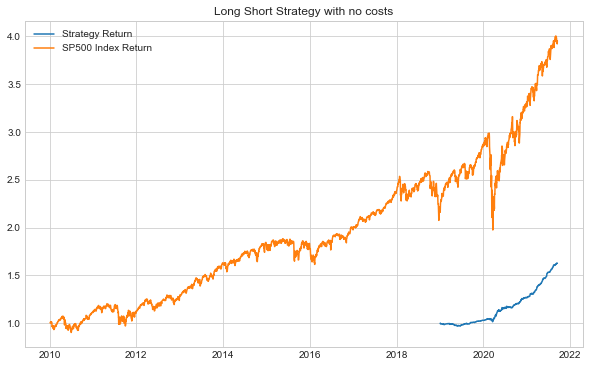

<Figure size 432x288 with 0 Axes>

In [40]:
plt.style.use('seaborn-whitegrid')
plt.figure(figsize=(10,6))
plt.plot(cumulative_ret1, label="Strategy Return")
plt.plot(SPX_cumret, label="SP500 Index Return")
plt.title("Long Short Strategy with no costs")
plt.legend(loc="upper left")
plt.show()
plt.savefig('str_ret.png')

### Long Only 

<Figure size 720x432 with 0 Axes>

Text(0.5, 1.0, 'Long Short Strategy with no costs')

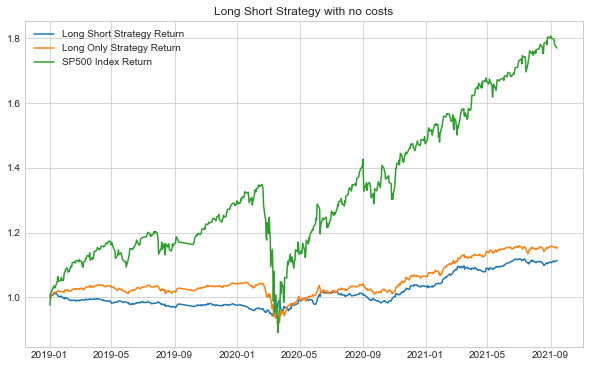

<Figure size 432x288 with 0 Axes>

In [30]:
retmatrix2 = retmatrix.copy()
def long_only(x):
    if x == 1:
        return x
    else:
        return 0

for i in range(len(retmatrix2.columns)):
    retmatrix2.iloc[:,i] = retmatrix2.iloc[:,i].apply(long_only)

    
def cumRet_long(test, col):
    test['position2'] = retmatrix2[col]
    test['ret2'] = test['Return of the Day'] * test['position2']
    test['cumret2'] = (1 + test['ret2']).cumprod()
    return test

XLF_test_n = cumRet_long(XLF_test_n,'XLF')
XLE_test_n = cumRet_long(XLE_test_n,'XLE')
XLU_test_n = cumRet_long(XLU_test_n,'XLU')
XLV_test_n = cumRet_long(XLV_test_n,'XLV')
XLI_test_n = cumRet_long(XLI_test_n,'XLI')
XLK_test_n = cumRet_long(XLK_test_n,'XLK')
XLP_test_n = cumRet_long(XLP_test_n,'XLP')
XLB_test_n = cumRet_long(XLB_test_n,'XLB')
XLY_test_n = cumRet_long(XLY_test_n,'XLY')
XLC_test_n = cumRet_long(XLC_test_n,'XLC')
XLRE_test_n = cumRet_long(XLRE_test_n,'XLRE')


cumulative_ret2 = (XLF_test_n['cumret2'] + XLE_test_n['cumret2'] + XLU_test_n['cumret2'] + XLV_test_n['cumret2'] + \
                 XLI_test_n['cumret2'] + XLK_test_n['cumret2'] + XLY_test_n['cumret2'] + XLP_test_n['cumret2'] + \
                 XLB_test_n['cumret2'] + XLC_test_n['cumret2'] + XLRE_test_n['cumret2'])/ 11

ret2 = (XLF_test_n['ret2'] + XLE_test_n['ret2'] + XLU_test_n['ret2'] + XLV_test_n['ret2'] + \
                 XLI_test_n['ret2'] + XLK_test_n['ret2'] + XLY_test_n['ret2'] + XLP_test_n['ret2'] + \
                 XLB_test_n['ret2'] + XLC_test_n['ret2'] + XLRE_test_n['ret2'])/11





plt.style.use('seaborn-whitegrid')
plt.figure(figsize=(10,6))
plt.plot(cumulative_ret1, label="Long Short Strategy Return")
plt.plot(cumulative_ret2, label="Long Only Strategy Return")
plt.plot(SPX_cumret, label="SP500 Index Return")
plt.title("Long Short Strategy with no costs")
plt.legend(loc="upper left")
plt.show()
plt.savefig('str_ret.png')

In [31]:
def performance(cumret,ret):
    N = 252
    annual_return = (cumret[-1] ** (N / len(cumret)) - 1)
    annual_volatility = ret.std() * np.sqrt(N)
    #print('annual return: {}%'.format(round((cumret[-1] ** (N / len(cumret)) - 1)*100, 2)))
    print('annual return: {}%'.format(round(annual_return*100, 2)))
    print('Sharpe Ratio: ', round((annual_return/annual_volatility),2))
    print('Max drop down: {}%'.format(round(((1 - cumret / cumret.cummax()).max())*100, 2)))
    print('Volatility: ', round(annual_volatility,4))

In [32]:
print("===================================")
print("long-short strategy without transaction costs: ")
performance(cumulative_ret1,ret1)

print("===================================")
print("long-only strategy without transaction costs: ")
performance(cumulative_ret2,ret2)


print("===================================")
print("SP500 Benchmark without transaction costs: ")
performance(SPX_cumret[:-1],SPX_ret[:-1])

long-short strategy without transaction costs: 
annual return: 4.79%
Sharpe Ratio:  1.13
Max drop down: 6.85%
Volatility:  0.0425
long-only strategy without transaction costs: 
annual return: 6.33%
Sharpe Ratio:  0.81
Max drop down: 11.89%
Volatility:  0.0782
SP500 Benchmark without transaction costs: 
annual return: 28.27%
Sharpe Ratio:  1.13
Max drop down: 33.92%
Volatility:  0.2493


## LSTM

In [33]:
import os
import sys
import io
import tensorflow as tf

import pandas as pd
import numpy as np
import random

import matplotlib.pyplot as plt

import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Conv1D,Conv2D, MaxPooling1D, MaxPooling2D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import RMSprop


from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.callbacks import ModelCheckpoint, LambdaCallback

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score

from tensorflow.keras.layers import Embedding
from tensorflow.keras import optimizers
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.utils import get_file
from tensorflow.keras.utils import plot_model

#from __future__ import print_function


from tensorflow.keras.utils import plot_model
import IPython

OUTPUT_PATH = ""

In [34]:
def build_timeseries(mat, y_col_index):
    # y_col_index is the index of column that would act as output column
    # total number of time-series samples would be len(mat) - TIME_STEPS
    dim_0 = mat.shape[0] - 5
    dim_1 = mat.shape[1]
    x = np.zeros((dim_0, 5, dim_1))
    y = np.zeros((dim_0,))
    
    for i in range(dim_0):
        x[i] = mat[i:5+i]
        y[i] = mat[5+i, y_col_index]
    print("length of time-series i/o",x.shape,y.shape)
    return x, y

def trim_dataset(mat, batch_size):
    """
    trims dataset to a size that's divisible by BATCH_SIZE
    """
    no_of_rows_drop = mat.shape[0]%batch_size
    if(no_of_rows_drop > 0):
        return mat[:-no_of_rows_drop]
    else:
        return mat

In [35]:
def trainModel(model,modelName, X_train, y_train, X_val, y_val):
    model.compile(loss="mse",
                optimizer="adam",
                metrics=["mse"])
    es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=.0005, patience=20, verbose=1, mode='auto', baseline=None, restore_best_weights=True)

    callbacks = [ es_callback,
                ModelCheckpoint(filepath=os.path.join(OUTPUT_PATH,modelName
                          + ".ckpt"), monitor='val_loss', save_best_only=True)
              ]   

    plotFile = modelName + ".png"
    plot_model(model, plotFile, show_shapes=True)
  

    history= model.fit(X_train, y_train,
            batch_size=128,
            epochs=40,
            verbose=1,
            callbacks=callbacks,
            validation_data=(X_val, y_val)
            )
  
    score = model.evaluate(X_val, y_val, verbose=0)
    print('Test loss:', score[0])
    #print('Test accuracy:', score[1])

    return history, score[1], plotFile

In [36]:
def CreateModel():  
    model=Sequential()
    model.add(Conv1D(filters=32, kernel_size=20, padding='same', activation='relu',input_shape= (5,12)))
    model.add(MaxPooling1D(pool_size=2))
    model.add(LSTM(100, dropout=0.0, recurrent_dropout=0.0))
    model.add(Dropout(0.4))
    model.add(BatchNormalization())
    model.add(Dense(256, activation='relu'))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1,activation = "linear"))
    return model

length of time-series i/o (1572, 5, 12) (1572,)
length of time-series i/o (193, 5, 12) (193,)
length of time-series i/o (192, 5, 12) (192,)
('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')
Epoch 1/40
 9/13 [===================>..........] - ETA: 0s - loss: 1.1883 - mse: 1.1883WARNING:tensorflow:From /Users/shengyuhuang/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/training/tracking/tracking.py:111: Model.state_updates (from tensorflow.python.keras.engine.training) is deprecated and will be removed in a future version.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: model_XLF.ckpt/assets
13/13 [==============================] - 5s 359ms/step - loss: 1.1571 - 

<Figure size 432x288 with 0 Axes>

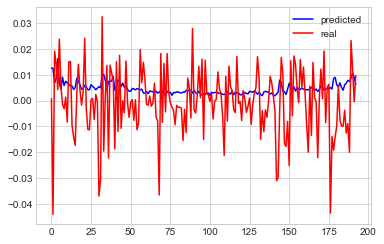

In [37]:
from sklearn.model_selection import train_test_split
train_cols = ['High','Low','Open','Volume','Adj Close','oil','gold','bond','vix','USD_JPY','SPX','Return of the Day']

XLF_train_scaled, XLF_test_scaled, XLF_mean, XLF_std = scaleData(XLF_train[train_cols], XLF_test[train_cols])


x_train, x_temp = train_test_split(XLF_train_scaled.values, train_size=0.8, test_size=0.2, shuffle=False)
x_val, x_test = train_test_split(x_temp, train_size=0.5, test_size=0.5, shuffle=False)

x_train, y_train = build_timeseries(x_train, 11)
x_test, y_test = build_timeseries(x_test, 11)
x_val, y_val = build_timeseries(x_val, 11)

model_XLF=CreateModel()
history, score, File=trainModel(model_XLF, 'model_XLF', x_train, y_train, x_val, y_val)


y_pred_xlf_test=model_XLF.predict(x_test)
y_pred_xlf_test = y_pred_xlf_test * XLF_std['Return of the Day'] + XLF_mean['Return of the Day']
y_test = y_test * XLF_std['Return of the Day'] + XLF_mean['Return of the Day']
plt.figure()
plt.plot(y_pred_xlf_test, "b", label="predicted")
plt.plot(y_test, "r", label="real")
plt.legend(loc="upper right")
plt.show()


length of time-series i/o (1572, 5, 12) (1572,)
length of time-series i/o (193, 5, 12) (193,)
length of time-series i/o (192, 5, 12) (192,)
('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')
Epoch 1/40
13/13 [==============================] - 5s 361ms/step - loss: 0.0276 - mse: 0.0276 - val_loss: 0.0020 - val_mse: 0.0020
Epoch 2/40
13/13 [==============================] - 4s 336ms/step - loss: 0.0089 - mse: 0.0089 - val_loss: 0.0013 - val_mse: 0.0013
Epoch 3/40
13/13 [==============================] - 0s 8ms/step - loss: 0.0044 - mse: 0.0044 - val_loss: 0.0016 - val_mse: 0.0016
Epoch 4/40
13/13 [==============================] - 4s 334ms/step - loss: 0.0032 - mse: 0.0032 - val_loss: 7.8776e-04 - val_mse: 7.8776e-04
Epoch 5/40
13/13 [==============================] - 4s 317ms/step - loss: 0.0027 - mse: 0.0027 - val_loss: 5.2961e-04 - val_mse: 5.2961e-04
Epoch 6/40
13/13 [====================

<Figure size 432x288 with 0 Axes>

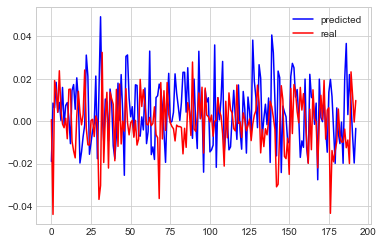

In [38]:
from sklearn.model_selection import train_test_split
train_cols = ['High','Low','Open','Volume','Adj Close','oil','gold','bond','vix','USD_JPY','SPX','Return of the Day']

x_train, x_temp = train_test_split(XLF_train[train_cols].values, train_size=0.8, test_size=0.2, shuffle=False)
x_val, x_test = train_test_split(x_temp, train_size=0.5, test_size=0.5, shuffle=False)

x_train, y_train = build_timeseries(x_train, 11)
x_test, y_test = build_timeseries(x_test, 11)
x_val, y_val = build_timeseries(x_val, 11)

model_XLF=CreateModel()
history, score, File=trainModel(model_XLF, 'model_XLF', x_train, y_train, x_val, y_val)

y_pred_xlf_test=model_XLF.predict(x_test)
plt.figure()
plt.plot(y_pred_xlf_test, "b", label="predicted")
plt.plot(y_test, "r", label="real")
plt.legend(loc="upper right")
plt.show()

In [39]:
def LSTM_train_pred(train, test, model_name, OUTPUT_PATH = ""):
    x_train, x_temp = train_test_split(train[train_cols].values, train_size=0.8, test_size=0.2, shuffle=False)
    x_val, x_test = train_test_split(x_temp, train_size=0.5, test_size=0.5, shuffle=False)

    x_train, y_train = build_timeseries(x_train, 11)
    x_test, y_test = build_timeseries(x_test, 11)
    x_val, y_val = build_timeseries(x_val, 11)

    model=CreateModel()
    history, score, File=trainModel(model, model_name, x_train, y_train, x_val, y_val)
    
    pred = test[train_cols].values
    x_pred, y_pred = build_timeseries(pred, 11)
    output=model.predict(x_pred)
    return output





In [40]:
XLF_LSTM_pred = LSTM_train_pred(XLF_train, XLF_test, 'model_XLF', OUTPUT_PATH = "")


length of time-series i/o (1572, 5, 12) (1572,)
length of time-series i/o (193, 5, 12) (193,)
length of time-series i/o (192, 5, 12) (192,)
('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')
Epoch 1/40
13/13 [==============================] - 4s 316ms/step - loss: 0.0795 - mse: 0.0795 - val_loss: 0.0086 - val_mse: 0.0086
Epoch 2/40
13/13 [==============================] - 4s 306ms/step - loss: 0.0132 - mse: 0.0132 - val_loss: 0.0013 - val_mse: 0.0013
Epoch 3/40
13/13 [==============================] - 0s 7ms/step - loss: 0.0062 - mse: 0.0062 - val_loss: 0.0017 - val_mse: 0.0017
Epoch 4/40
13/13 [==============================] - 4s 285ms/step - loss: 0.0043 - mse: 0.0043 - val_loss: 8.5736e-04 - val_mse: 8.5736e-04
Epoch 5/40
13/13 [==============================] - 4s 316ms/step - loss: 0.0034 - mse: 0.0034 - val_loss: 7.3198e-04 - val_mse: 7.3198e-04
Epoch 6/40
13/13 [====================

Epoch 38/40
13/13 [==============================] - 5s 348ms/step - loss: 3.7367e-04 - mse: 3.7367e-04 - val_loss: 1.1053e-04 - val_mse: 1.1053e-04
Epoch 39/40
13/13 [==============================] - 4s 329ms/step - loss: 3.5299e-04 - mse: 3.5299e-04 - val_loss: 1.0800e-04 - val_mse: 1.0800e-04
Epoch 40/40
11/13 [========================>.....] - ETA: 0s - loss: 3.5477e-04 - mse: 3.5477e-04Restoring model weights from the end of the best epoch.
INFO:tensorflow:Assets written to: model_XLF.ckpt/assets
13/13 [==============================] - 4s 322ms/step - loss: 3.5922e-04 - mse: 3.5922e-04 - val_loss: 1.0287e-04 - val_mse: 1.0287e-04
Epoch 00040: early stopping
Test loss: 0.00017843862588051707
length of time-series i/o (574, 5, 12) (574,)


In [41]:
XLE_LSTM_pred = LSTM_train_pred(XLE_train, XLE_test, 'model_XLE', OUTPUT_PATH = "")

length of time-series i/o (1572, 5, 12) (1572,)
length of time-series i/o (193, 5, 12) (193,)
length of time-series i/o (192, 5, 12) (192,)
('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')
Epoch 1/40
13/13 [==============================] - 5s 357ms/step - loss: 0.0228 - mse: 0.0228 - val_loss: 0.0029 - val_mse: 0.0029
Epoch 2/40
13/13 [==============================] - 4s 317ms/step - loss: 0.0062 - mse: 0.0062 - val_loss: 0.0015 - val_mse: 0.0015
Epoch 3/40
13/13 [==============================] - 4s 339ms/step - loss: 0.0031 - mse: 0.0031 - val_loss: 9.7865e-04 - val_mse: 9.7865e-04
Epoch 4/40
13/13 [==============================] - 4s 313ms/step - loss: 0.0018 - mse: 0.0018 - val_loss: 3.8968e-04 - val_mse: 3.8968e-04
Epoch 5/40
13/13 [==============================] - 4s 314ms/step - loss: 0.0013 - mse: 0.0013 - val_loss: 2.5921e-04 - val_mse: 2.5921e-04
Epoch 6/40
13/13 [==========

In [42]:
XLU_LSTM_pred = LSTM_train_pred(XLU_train, XLU_test, 'model_XLU', OUTPUT_PATH = "")

length of time-series i/o (1572, 5, 12) (1572,)
length of time-series i/o (193, 5, 12) (193,)
length of time-series i/o (192, 5, 12) (192,)
('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')
Epoch 1/40
13/13 [==============================] - 5s 356ms/step - loss: 0.0472 - mse: 0.0472 - val_loss: 0.0043 - val_mse: 0.0043
Epoch 2/40
13/13 [==============================] - 4s 316ms/step - loss: 0.0125 - mse: 0.0125 - val_loss: 0.0015 - val_mse: 0.0015
Epoch 3/40
13/13 [==============================] - 4s 288ms/step - loss: 0.0060 - mse: 0.0060 - val_loss: 0.0012 - val_mse: 0.0012
Epoch 4/40
13/13 [==============================] - 4s 335ms/step - loss: 0.0042 - mse: 0.0042 - val_loss: 8.4152e-04 - val_mse: 8.4152e-04
Epoch 5/40
13/13 [==============================] - 4s 330ms/step - loss: 0.0034 - mse: 0.0034 - val_loss: 7.1354e-04 - val_mse: 7.1354e-04
Epoch 6/40
13/13 [==================

In [43]:
XLV_LSTM_pred = LSTM_train_pred(XLV_train, XLV_test, 'model_XLV', OUTPUT_PATH = "")

length of time-series i/o (1572, 5, 12) (1572,)
length of time-series i/o (193, 5, 12) (193,)
length of time-series i/o (192, 5, 12) (192,)
('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')
Epoch 1/40
13/13 [==============================] - 5s 351ms/step - loss: 0.0162 - mse: 0.0162 - val_loss: 0.0022 - val_mse: 0.0022
Epoch 2/40
13/13 [==============================] - 4s 310ms/step - loss: 0.0065 - mse: 0.0065 - val_loss: 8.2382e-04 - val_mse: 8.2382e-04
Epoch 3/40
13/13 [==============================] - 4s 311ms/step - loss: 0.0035 - mse: 0.0035 - val_loss: 4.7627e-04 - val_mse: 4.7627e-04
Epoch 4/40
13/13 [==============================] - 4s 306ms/step - loss: 0.0024 - mse: 0.0024 - val_loss: 2.6795e-04 - val_mse: 2.6795e-04
Epoch 5/40
13/13 [==============================] - 0s 6ms/step - loss: 0.0017 - mse: 0.0017 - val_loss: 2.7286e-04 - val_mse: 2.7286e-04
Epoch 6/40
13/13 [====

In [44]:
XLI_LSTM_pred = LSTM_train_pred(XLI_train, XLI_test, 'model_XLI', OUTPUT_PATH = "")

length of time-series i/o (1572, 5, 12) (1572,)
length of time-series i/o (193, 5, 12) (193,)
length of time-series i/o (192, 5, 12) (192,)
('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')
Epoch 1/40
13/13 [==============================] - 5s 362ms/step - loss: 0.0436 - mse: 0.0436 - val_loss: 0.0084 - val_mse: 0.0084
Epoch 2/40
13/13 [==============================] - 4s 321ms/step - loss: 0.0097 - mse: 0.0097 - val_loss: 0.0017 - val_mse: 0.0017
Epoch 3/40
13/13 [==============================] - 4s 324ms/step - loss: 0.0051 - mse: 0.0051 - val_loss: 0.0014 - val_mse: 0.0014
Epoch 4/40
13/13 [==============================] - 4s 323ms/step - loss: 0.0035 - mse: 0.0035 - val_loss: 0.0010 - val_mse: 0.0010
Epoch 5/40
13/13 [==============================] - 4s 317ms/step - loss: 0.0024 - mse: 0.0024 - val_loss: 5.5999e-04 - val_mse: 5.5999e-04
Epoch 6/40
13/13 [==========================

In [45]:
XLK_LSTM_pred = LSTM_train_pred(XLK_train, XLK_test, 'model_XLK', OUTPUT_PATH = "")

length of time-series i/o (1572, 5, 12) (1572,)
length of time-series i/o (193, 5, 12) (193,)
length of time-series i/o (192, 5, 12) (192,)
('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')
Epoch 1/40
13/13 [==============================] - 5s 358ms/step - loss: 0.0190 - mse: 0.0190 - val_loss: 0.0033 - val_mse: 0.0033
Epoch 2/40
13/13 [==============================] - 4s 316ms/step - loss: 0.0048 - mse: 0.0048 - val_loss: 7.1466e-04 - val_mse: 7.1466e-04
Epoch 3/40
13/13 [==============================] - 4s 324ms/step - loss: 0.0029 - mse: 0.0029 - val_loss: 6.0092e-04 - val_mse: 6.0092e-04
Epoch 4/40
13/13 [==============================] - 4s 337ms/step - loss: 0.0021 - mse: 0.0021 - val_loss: 3.6530e-04 - val_mse: 3.6530e-04
Epoch 5/40
13/13 [==============================] - 0s 7ms/step - loss: 0.0016 - mse: 0.0016 - val_loss: 6.6647e-04 - val_mse: 6.6647e-04
Epoch 6/40
13/13 [====

In [46]:
XLP_LSTM_pred = LSTM_train_pred(XLP_train, XLP_test, 'model_XLP', OUTPUT_PATH = "")

length of time-series i/o (1572, 5, 12) (1572,)
length of time-series i/o (193, 5, 12) (193,)
length of time-series i/o (192, 5, 12) (192,)
('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')
Epoch 1/40
13/13 [==============================] - 5s 358ms/step - loss: 0.0531 - mse: 0.0531 - val_loss: 0.0034 - val_mse: 0.0034
Epoch 2/40
13/13 [==============================] - 4s 309ms/step - loss: 0.0078 - mse: 0.0078 - val_loss: 8.7378e-04 - val_mse: 8.7378e-04
Epoch 3/40
13/13 [==============================] - 4s 318ms/step - loss: 0.0043 - mse: 0.0043 - val_loss: 4.6802e-04 - val_mse: 4.6802e-04
Epoch 4/40
13/13 [==============================] - 4s 333ms/step - loss: 0.0027 - mse: 0.0027 - val_loss: 4.2730e-04 - val_mse: 4.2730e-04
Epoch 5/40
13/13 [==============================] - 4s 298ms/step - loss: 0.0021 - mse: 0.0021 - val_loss: 4.0522e-04 - val_mse: 4.0522e-04
Epoch 6/40
13/13 [==

In [47]:
XLB_LSTM_pred = LSTM_train_pred(XLB_train, XLB_test, 'model_XLB', OUTPUT_PATH = "")

length of time-series i/o (1572, 5, 12) (1572,)
length of time-series i/o (193, 5, 12) (193,)
length of time-series i/o (192, 5, 12) (192,)
('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')
Epoch 1/40
13/13 [==============================] - 5s 366ms/step - loss: 0.0328 - mse: 0.0328 - val_loss: 0.0073 - val_mse: 0.0073
Epoch 2/40
13/13 [==============================] - 4s 301ms/step - loss: 0.0080 - mse: 0.0080 - val_loss: 0.0019 - val_mse: 0.0019
Epoch 3/40
13/13 [==============================] - 4s 334ms/step - loss: 0.0043 - mse: 0.0043 - val_loss: 6.3172e-04 - val_mse: 6.3172e-04
Epoch 4/40
13/13 [==============================] - 0s 6ms/step - loss: 0.0032 - mse: 0.0032 - val_loss: 7.3926e-04 - val_mse: 7.3926e-04
Epoch 5/40
13/13 [==============================] - 0s 6ms/step - loss: 0.0022 - mse: 0.0022 - val_loss: 8.4783e-04 - val_mse: 8.4783e-04
Epoch 6/40
13/13 [==============

In [48]:
XLY_LSTM_pred = LSTM_train_pred(XLY_train, XLY_test, 'model_XLY', OUTPUT_PATH = "")

length of time-series i/o (1572, 5, 12) (1572,)
length of time-series i/o (193, 5, 12) (193,)
length of time-series i/o (192, 5, 12) (192,)
('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')
Epoch 1/40
13/13 [==============================] - 5s 373ms/step - loss: 0.0492 - mse: 0.0492 - val_loss: 0.0018 - val_mse: 0.0018
Epoch 2/40
13/13 [==============================] - 4s 323ms/step - loss: 0.0097 - mse: 0.0097 - val_loss: 0.0011 - val_mse: 0.0011
Epoch 3/40
13/13 [==============================] - 4s 334ms/step - loss: 0.0047 - mse: 0.0047 - val_loss: 5.7178e-04 - val_mse: 5.7178e-04
Epoch 4/40
13/13 [==============================] - 0s 6ms/step - loss: 0.0030 - mse: 0.0030 - val_loss: 6.0247e-04 - val_mse: 6.0247e-04
Epoch 5/40
13/13 [==============================] - 4s 322ms/step - loss: 0.0025 - mse: 0.0025 - val_loss: 3.6602e-04 - val_mse: 3.6602e-04
Epoch 6/40
13/13 [============

In [49]:
XLC_LSTM_pred = LSTM_train_pred(XLC_train, XLC_test, 'model_XLC', OUTPUT_PATH = "")

length of time-series i/o (84, 5, 12) (84,)
length of time-series i/o (7, 5, 12) (7,)
length of time-series i/o (6, 5, 12) (6,)
('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')
Epoch 1/40
1/1 [==============================] - 4s 4s/step - loss: 0.0600 - mse: 0.0600 - val_loss: 0.0377 - val_mse: 0.0377
Epoch 2/40
1/1 [==============================] - 4s 4s/step - loss: 0.0683 - mse: 0.0683 - val_loss: 0.0122 - val_mse: 0.0122
Epoch 3/40
1/1 [==============================] - 4s 4s/step - loss: 0.0539 - mse: 0.0539 - val_loss: 0.0028 - val_mse: 0.0028
Epoch 4/40
1/1 [==============================] - 0s 17ms/step - loss: 0.0348 - mse: 0.0348 - val_loss: 0.0056 - val_mse: 0.0056
Epoch 5/40
1/1 [==============================] - 0s 20ms/step - loss: 0.0436 - mse: 0.0436 - val_loss: 0.0062 - val_mse: 0.0062
Epoch 6/40
1/1 [==============================] - 0s 18ms/step - loss: 0.0219 - mse: 

In [50]:
XLRE_LSTM_pred = LSTM_train_pred(XLRE_train, XLRE_test, 'model_XLRE', OUTPUT_PATH = "")

length of time-series i/o (561, 5, 12) (561,)
length of time-series i/o (66, 5, 12) (66,)
length of time-series i/o (66, 5, 12) (66,)
('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')
Epoch 1/40
5/5 [==============================] - 4s 866ms/step - loss: 0.1094 - mse: 0.1094 - val_loss: 0.0281 - val_mse: 0.0281
Epoch 2/40
5/5 [==============================] - 4s 756ms/step - loss: 0.0366 - mse: 0.0366 - val_loss: 0.0064 - val_mse: 0.0064
Epoch 3/40
5/5 [==============================] - 4s 859ms/step - loss: 0.0218 - mse: 0.0218 - val_loss: 0.0056 - val_mse: 0.0056
Epoch 4/40
5/5 [==============================] - 4s 817ms/step - loss: 0.0154 - mse: 0.0154 - val_loss: 0.0047 - val_mse: 0.0047
Epoch 5/40
5/5 [==============================] - 4s 846ms/step - loss: 0.0114 - mse: 0.0114 - val_loss: 0.0017 - val_mse: 0.0017
Epoch 6/40
5/5 [==============================] - 0s 8ms/step - loss

Epoch 40/40
5/5 [==============================] - 0s 8ms/step - loss: 0.0012 - mse: 0.0012 - val_loss: 2.7589e-04 - val_mse: 2.7589e-04
Test loss: 0.00027588597731664777
length of time-series i/o (574, 5, 12) (574,)


In [51]:
date = XLF_test.index[5:]
d = {'xlb': XLB_LSTM_pred.flatten(),'xle':XLE_LSTM_pred.flatten(),'xlf':XLF_LSTM_pred.flatten(),'xli':XLI_LSTM_pred.flatten(),\
     'xlk':XLK_LSTM_pred.flatten(),'xlp':XLP_LSTM_pred.flatten(),'xlu':XLU_LSTM_pred.flatten(),'xlv':XLV_LSTM_pred.flatten(),\
     'xly':XLY_LSTM_pred.flatten(), 'xlc':XLC_LSTM_pred.flatten(), 'xlre':XLRE_LSTM_pred.flatten()}
retmatrix = pd.DataFrame(data = d,index=date)
retmatrix = retmatrix.rank(method = 'first',ascending = False, axis = 1)
for i in range(len(retmatrix.columns)):
    retmatrix.iloc[:,i] = retmatrix.iloc[:,i].apply(get_position)
    


In [52]:
retmatrix

,xlb,xle,xlf,xli,xlk,xlp,xlu,xlv,xly,xlc,xlre
Date,,,,,,,,,,,
2019-01-09,0,0,1,0,-1,0,1,0,-1,-1,1
2019-01-10,-1,-1,0,0,0,0,0,-1,1,1,1
2019-01-11,-1,1,0,1,-1,0,0,-1,1,0,0
2019-01-14,0,-1,0,0,0,1,0,-1,-1,1,1
2019-01-15,0,-1,-1,1,0,0,1,0,0,-1,1
...,...,...,...,...,...,...,...,...,...,...,...
2021-09-07,0,0,-1,-1,1,0,0,-1,0,1,1
2021-09-08,0,-1,0,0,0,1,1,0,-1,1,-1
2021-09-09,0,0,1,-1,0,1,-1,0,1,-1,0


In [53]:
XLB_test_lstm = XLB_test.iloc[5:,].copy()
XLE_test_lstm = XLE_test.iloc[5:,].copy()
XLF_test_lstm = XLF_test.iloc[5:,].copy()
XLI_test_lstm = XLI_test.iloc[5:,].copy()
XLK_test_lstm = XLK_test.iloc[5:,].copy()
XLP_test_lstm = XLP_test.iloc[5:,].copy()
XLU_test_lstm = XLU_test.iloc[5:,].copy()
XLV_test_lstm = XLV_test.iloc[5:,].copy()
XLY_test_lstm = XLY_test.iloc[5:,].copy()
XLC_test_lstm = XLC_test.iloc[5:,].copy()
XLRE_test_lstm = XLRE_test.iloc[5:,].copy()

In [54]:
XLB_test_lstm = cumRet(XLB_test_lstm,'xlb')
XLE_test_lstm = cumRet(XLE_test_lstm,'xle')
XLF_test_lstm = cumRet(XLF_test_lstm,'xlf')
XLI_test_lstm = cumRet(XLI_test_lstm,'xli')
XLK_test_lstm = cumRet(XLK_test_lstm,'xlk')
XLP_test_lstm = cumRet(XLP_test_lstm,'xlp')
XLU_test_lstm = cumRet(XLU_test_lstm,'xlu')
XLV_test_lstm = cumRet(XLV_test_lstm,'xlv')
XLY_test_lstm = cumRet(XLY_test_lstm,'xly')
XLC_test_lstm = cumRet(XLC_test_lstm,'xly')
XLC_test_lstm = cumRet(XLRE_test_lstm,'xly')

In [55]:
cumulative_ret1 = (XLF_test_lstm['cumret'] + XLE_test_lstm['cumret'] + XLU_test_lstm['cumret'] + XLV_test_lstm['cumret'] + \
                 XLI_test_lstm['cumret'] + XLK_test_lstm['cumret'] + XLY_test_lstm['cumret'] + XLP_test_lstm['cumret'] + \
                 XLB_test_lstm['cumret'] + XLC_test_lstm['cumret'] + XLRE_test_lstm['cumret']) / 11



ret1 = (XLF_test_lstm['ret'] + XLE_test_lstm['ret'] + XLU_test_lstm['ret'] + XLV_test_lstm['ret'] + \
                 XLI_test_lstm['ret'] + XLK_test_lstm['ret'] + XLY_test_lstm['ret'] + XLP_test_lstm['ret'] + \
                 XLB_test_lstm['ret'] + XLC_test_lstm['ret'] + XLRE_test_lstm['ret']) / 11


#SPX
SPX_ret = XLF_test_lstm['SPX'].pct_change().shift(-1)
SPX_ret = SPX_ret[:-1]
SPX_cumret = (1 + SPX_ret).cumprod()

In [56]:
#Long Only Strategy

retmatrix2 = retmatrix.copy()

for i in range(len(retmatrix2.columns)):
    retmatrix2.iloc[:,i] = retmatrix2.iloc[:,i].apply(long_only)
    
    
XLB_test_lstm = cumRet_long(XLB_test_lstm,'xlb')
XLE_test_lstm = cumRet_long(XLE_test_lstm,'xle')
XLF_test_lstm = cumRet_long(XLF_test_lstm,'xlf')
XLI_test_lstm = cumRet_long(XLI_test_lstm,'xli')
XLK_test_lstm = cumRet_long(XLK_test_lstm,'xlk')
XLP_test_lstm = cumRet_long(XLP_test_lstm,'xlp')
XLU_test_lstm = cumRet_long(XLU_test_lstm,'xlu')
XLV_test_lstm = cumRet_long(XLV_test_lstm,'xlv')
XLY_test_lstm = cumRet_long(XLY_test_lstm,'xly')
XLC_test_lstm = cumRet_long(XLC_test_lstm,'xly')
XLC_test_lstm = cumRet_long(XLRE_test_lstm,'xly')

cumulative_ret2 = (XLF_test_lstm['cumret2'] + XLE_test_lstm['cumret2'] + XLU_test_lstm['cumret2'] + XLV_test_lstm['cumret2'] + \
                 XLI_test_lstm['cumret2'] + XLK_test_lstm['cumret2'] + XLY_test_lstm['cumret2'] + XLP_test_lstm['cumret2'] + \
                 XLB_test_lstm['cumret2'] + XLC_test_lstm['cumret2'] + XLRE_test_lstm['cumret2']) / 11


ret2 = (XLF_test_lstm['ret2'] + XLE_test_lstm['ret2'] + XLU_test_lstm['ret2'] + XLV_test_lstm['ret2'] + \
                 XLI_test_lstm['ret2'] + XLK_test_lstm['ret2'] + XLY_test_lstm['ret2'] + XLP_test_lstm['ret2'] + \
                 XLB_test_lstm['ret2'] + XLC_test_lstm['ret2'] + XLRE_test_lstm['ret2']) / 11

<Figure size 720x432 with 0 Axes>

Text(0.5, 1.0, 'Long Short Strategy with no costs')

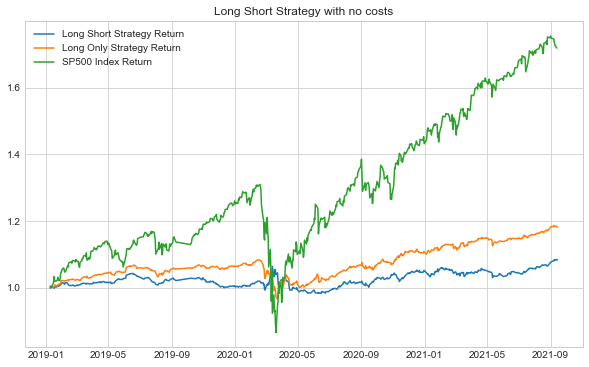

<Figure size 432x288 with 0 Axes>

In [57]:
plt.style.use('seaborn-whitegrid')
plt.figure(figsize=(10,6))
plt.plot(cumulative_ret1, label="Long Short Strategy Return")
plt.plot(cumulative_ret2, label="Long Only Strategy Return")
plt.plot(SPX_cumret, label="SP500 Index Return")
plt.title("Long Short Strategy with no costs")
plt.legend(loc="upper left")
plt.show()
plt.savefig('str_ret.png')

In [58]:
print("===================================")
print("long-short strategy without transaction costs: ")
performance(cumulative_ret1,ret1)

print("===================================")
print("long-only strategy without transaction costs: ")
performance(cumulative_ret2,ret2)


print("===================================")
print("SP500 Benchmark without transaction costs: ")
performance(SPX_cumret,SPX_ret)


long-short strategy without transaction costs: 
annual return: 3.57%
Sharpe Ratio:  0.58
Max drop down: 7.62%
Volatility:  0.0613
long-only strategy without transaction costs: 
annual return: 7.58%
Sharpe Ratio:  0.92
Max drop down: 10.89%
Volatility:  0.082
SP500 Benchmark without transaction costs: 
annual return: 26.9%
Sharpe Ratio:  1.08
Max drop down: 33.92%
Volatility:  0.2487


In [66]:
model.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_13 (Conv1D)           (None, 5, 32)             7712      
_________________________________________________________________
max_pooling1d_13 (MaxPooling (None, 2, 32)             0         
_________________________________________________________________
lstm_13 (LSTM)               (None, 100)               53200     
_________________________________________________________________
dropout_13 (Dropout)         (None, 100)               0         
_________________________________________________________________
batch_normalization_13 (Batc (None, 100)               400       
_________________________________________________________________
dense_52 (Dense)             (None, 256)               25856     
_________________________________________________________________
dense_53 (Dense)             (None, 128)             